In [6]:
import torch
import torchvision
from torch.utils.data import DataLoader, ConcatDataset
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import ODIN, MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import LSUNResize

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import pickle
import numpy as np
from tqdm import tqdm

In [7]:
## Create Neural Network
device = "cuda" if torch.cuda.is_available() else "cpu"
model = WideResNet(num_classes=10, pretrained="cifar10-pt")
model.eval().to(device)
# Create detector
detector = ODIN(model)
# Instantiate metrics
metrics = OODMetrics()

## Define Test Set
trans = WideResNet.transform_for("cifar10-pt")
norm_std = WideResNet.norm_std_for("cifar10-pt")
# Load CIFAR-10 test set
cifar10_test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=trans)
# Load LSUN test set
lsun_test = LSUNResize(root="./data", download=True, transform=trans)

test_loader = DataLoader(cifar10_test+lsun_test, batch_size=128, shuffle=False)

Files already downloaded and verified


In [8]:
def ood_detection(detector, model_name):
    metrics = OODMetrics()
    all_scores, all_labels = [], []
    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc=f'Processing batches with {model_name}'):
            data = data.to(device)
            labels = labels.numpy()
            binary_labels = np.where(labels >= 0, 0, 1)
            
            # For detectors which needs gradients
            data.requires_grad = True
            outputs = detector(data)
            data.requires_grad = False
            scores = outputs.cpu().numpy()
            
            all_scores.extend(scores)
            all_labels.extend(binary_labels)
            
            metrics.update(outputs, torch.tensor(labels))
    result = metrics.compute()
    print(f"{model_name} OOD Detection Results: {result}")
    return all_labels, all_scores, result

In [9]:
## Compute metrics
msp_detector = MaxSoftmax(model)
odin_default_detector = ODIN(model)
odin_cifar10_detector = ODIN(model, eps=0.002, norm_std=norm_std)

# Perform OOD detection for each detector
print("Performing OOD detection with MSP...")
msp_labels, msp_scores, msp_result = ood_detection(msp_detector, "MSP")

print("\nPerforming OOD detection with ODIN (Default Hyperparameters)...")
odin_default_labels, odin_default_scores, odin_default_result = ood_detection(odin_default_detector, "ODIN Default")

print("\nPerforming OOD detection with ODIN (CIFAR-10 Hyperparameters)...")
odin_cifar10_labels, odin_cifar10_scores, odin_cifar10_result = ood_detection(odin_cifar10_detector, "ODIN CIFAR-10")

Performing OOD detection with MSP...


Processing batches with MSP: 100%|██████████| 157/157 [00:11<00:00, 13.63it/s]


MSP OOD Detection Results: {'AUROC': 0.9107536673545837, 'AUPR-IN': 0.9226487278938293, 'AUPR-OUT': 0.8906269073486328, 'FPR95TPR': 0.3041999936103821}

Performing OOD detection with ODIN (Default Hyperparameters)...


Processing batches with ODIN Default: 100%|██████████| 157/157 [00:31<00:00,  4.97it/s]


ODIN Default OOD Detection Results: {'AUROC': 0.6747255325317383, 'AUPR-IN': 0.7201293706893921, 'AUPR-OUT': 0.5914527177810669, 'FPR95TPR': 0.7110999822616577}

Performing OOD detection with ODIN (CIFAR-10 Hyperparameters)...


Processing batches with ODIN CIFAR-10: 100%|██████████| 157/157 [00:35<00:00,  4.40it/s]

ODIN CIFAR-10 OOD Detection Results: {'AUROC': 0.9433868527412415, 'AUPR-IN': 0.945250391960144, 'AUPR-OUT': 0.9413783550262451, 'FPR95TPR': 0.2752000093460083}


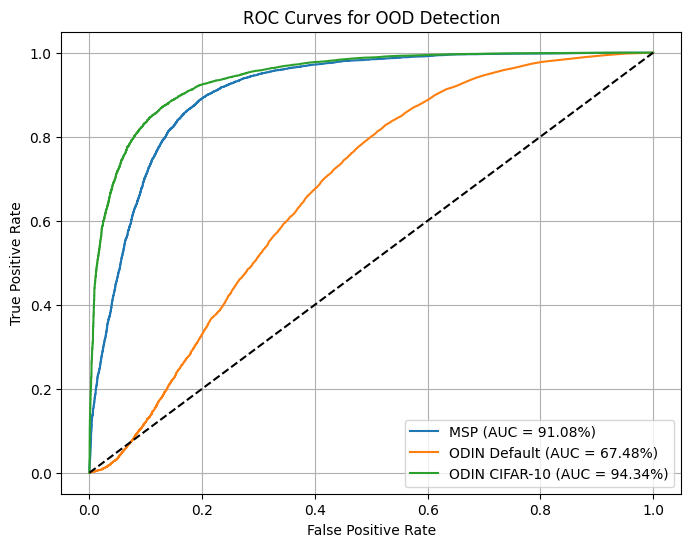

In [10]:
## Plot curves
plt.figure(figsize=(8, 6))
# MSP ROC Curve
fpr_msp, tpr_msp, _ = roc_curve(msp_labels, msp_scores)
roc_auc_msp = auc(fpr_msp, tpr_msp)
plt.plot(fpr_msp, tpr_msp, label="MSP (AUC = {:.2f}%)".format(roc_auc_msp * 100))

# ODIN Default ROC Curve
fpr_odin_def, tpr_odin_def, _ = roc_curve(odin_default_labels, odin_default_scores)
roc_auc_odin_def = auc(fpr_odin_def, tpr_odin_def)
plt.plot(fpr_odin_def, tpr_odin_def, label="ODIN Default (AUC = {:.2f}%)".format(roc_auc_odin_def * 100))

# ODIN CIFAR-10 ROC Curve
fpr_odin_c10, tpr_odin_c10, _ = roc_curve(odin_cifar10_labels, odin_cifar10_scores)
roc_auc_odin_c10 = auc(fpr_odin_c10, tpr_odin_c10)
plt.plot(fpr_odin_c10, tpr_odin_c10, label="ODIN CIFAR-10 (AUC = {:.2f}%)".format(roc_auc_odin_c10 * 100))

# Plot settings
plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for OOD Detection")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()